# Visualization
Questions:
* Plot a histogram of the processed amounts of each transaction, the transactionAmount column.
* Report any structure you find and any hypotheses you have about that structure.

The following sections summarize my findings for each question above. Each subsection begins with a summary of results and is following by supporting details and the Python scripts used to generate those results.

# Imports

In [1]:
# Data Wrangling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical Analysis
from scipy import stats
from distfit import distfit

# Utils
import os
from IPython.display import display

# Data loading and cleaning functions
from data_load_clean import get_transaction_data, clean_transation_data


# Load and Clean Data

In [2]:
# Load and Clean data using scripts in data_clean_load.py
# These scripts were developed during the data cleaning and analysis process
df_raw = get_transaction_data()
df = clean_transation_data(df_raw)

# Conclusions from Visualization
Visualizing the distribution of transaction amounts suggests that the data is exponentially distributed (see the historgram in the following cells). However, drilling-down into the distribution of data by transaction type suggested that around 20,000 address verification transactions were inflating the distribution near 0. Repeating the visualization for only purchase transactions showed peak in the frequency of transactions between $3 and $9, after which the frequency of larger transactions slowly decreased. The visualization suggested a gamma distribution or mixed distribution may be more appropriate for representing the purchases.

These hypotheses were tested by fitting multiple distributions to the emperical data and comparing the goodness-of-fit between the emperical data and the fitted distribution. Goodness-of-fit was evaluated using residual sum of squares. Testing the distributions indicated that exponential, gamma, and beta distributions provided the best fit to both sets of emperical data (all three had similar goodness-of-fit). All transation data was best fit by a beta distribution and the purchase transactions were best fit by a gamma distribution. The results support the initial hypotheses generated from visual inspection of all transactions and only purchases

Regardless of the specific distribution used to represent the data, it is clear that transcations with lower amounts are more frequent than transactions with higher amounts (as indicated by the right-skew of the distribution). This could arise from a few real-world behaviors. First, individuals may just make large transactions less frequently. Day-to-day spending is typically multiple small purchases, punctuated by periodic large purchases or recurring payments. Second, the set of large transcations may capture a few accounts that have different purchasing habits than the majority of the sample. If the right tail of the distribution is comprised of a specific set of accounts, it would suggest that the transaction amount data represents of mix of multiple distributions. Leveraging this mixture to address specific customer segments could be relevant for business outcomes including customer value, marketing campaigns and fraud detections. 

Questions for subject matter experts:
* What is known about customer purchasing habits and are the data reflecting those habits?
* Are there temporal dynamics in purchasing that could be masked by only looking 2016?
* Assuming the 5000 customers in this data are a sample of all transactions, is that sample representative or is it pulled from a particular customer segment? Would you expect purchasing trends to be different in other segments?

Analytic next steps, given more time:
* Test if the distribution represents distinct customer segements, e.g. high and low spenders.
* Evaluate the distribution over the course of 2016 for the sample and trends on individual accounts.
    * This analysis would help me understand if past purchase amounts are correlated with future purchase amounts. If there is a correlation, it would suggest an interesting dynamic in customer habits and be cause for modeling the data from a time-series perspective.
* Compare the distribution below to other years and customer segements to understand how this group of customers may differ from other samples. This analysis would be particularly relevant if there was a business decision being considered that would have implications for a larger demographic of customers than is captured in this sample.



## Visualization
The following cells plot the emperical data using a histogram. The histogram shows the frequency of various ranges (bins) of transaction amounts in order to visualize the distribution of the data. The histogram is visualized for three different numbers of bins to assess if patterns emerged at with finer splits of the data.   

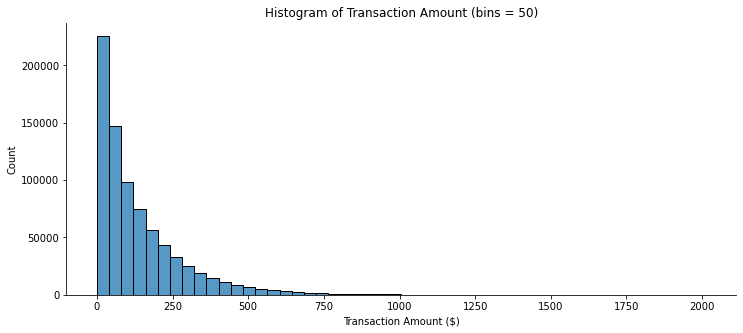

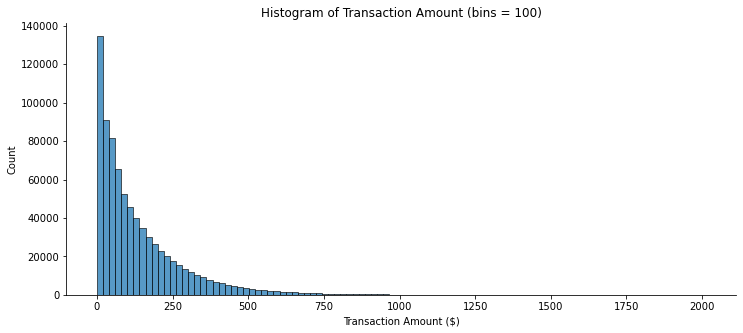

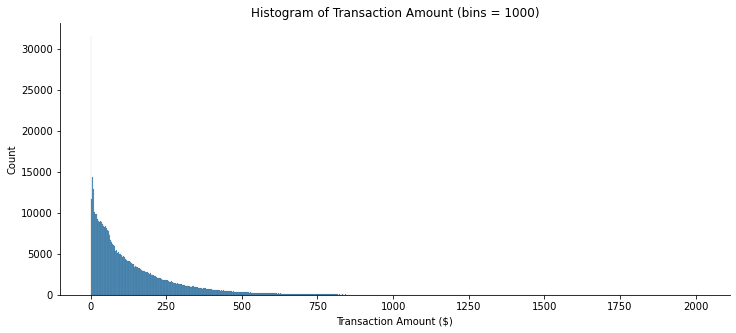

In [9]:
"""
Plot a histogram of the processed amounts of each transaction, 
the transactionAmount column.
"""

# Visualize histogram using seaborn
# Inspect different bin sizes to evaluate distribution
for bin_size in [50,100,1000]:
    plt.figure(figsize = (12,5))
    sns.histplot(df['transactionAmount'], bins=bin_size)
    plt.title('Histogram of Transaction Amount (bins = {})'.format(bin_size))
    plt.xlabel('Transaction Amount ($)')
    sns.despine()

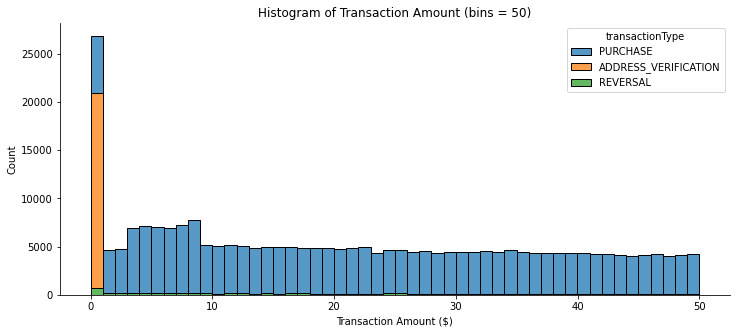

In [41]:
"""
Noticing the spike in the data near 0 with 1000 bins, we drill-down into that 
section of the data. Based on the descriptive stastics results, we consider how 
transaction amount changes by the type of transaction.
"""
bin_size=50
plt.figure(figsize = (12,5))
sns.histplot(data = df[df['transactionAmount']<50],
             x = 'transactionAmount', 
             bins=bin_size,hue='transactionType',
             multiple="stack")
plt.title('Histogram of Transaction Amount (bins = {})'.format(bin_size))
plt.xlabel('Transaction Amount ($)')
sns.despine()


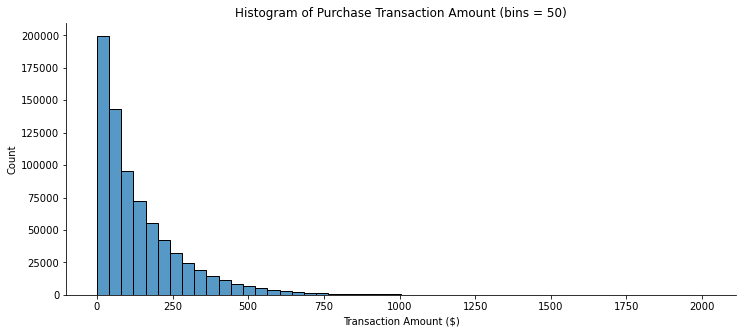

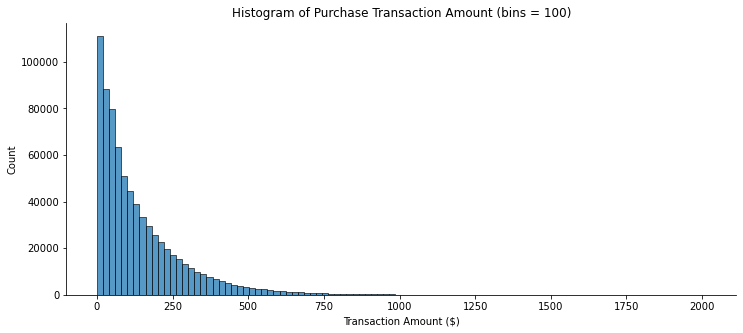

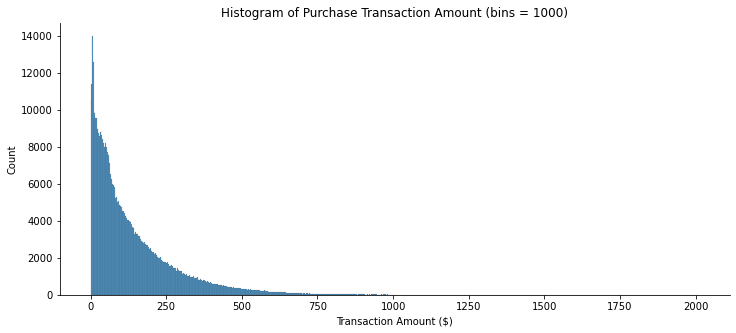

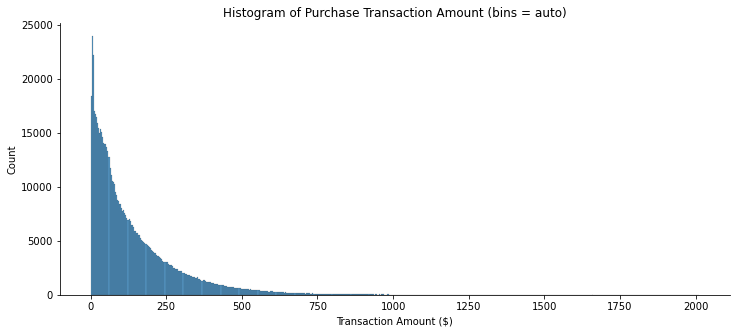

In [36]:
"""
Plot a histogram of the processed amounts of each transaction, 
the transactionAmount column. This time, only consider purchases
"""

# Visualize histogram using seaborn
# Inspect different bin sizes to evaluate distribution
for bin_size in [50,100,1000,'auto']:
    plt.figure(figsize = (12,5))
    sns.histplot(df[df['transactionType']=='PURCHASE']['transactionAmount'], bins=bin_size)
    plt.title('Histogram of Purchase Transaction Amount (bins = {})'.format(bin_size))
    plt.xlabel('Transaction Amount ($)')
    sns.despine()

Start of bins: Count of transactions


{0.0: 5951,
 0.9998999999999999: 4505,
 1.9997999999999998: 4618,
 2.9997: 6728,
 3.9995999999999996: 6968,
 4.999499999999999: 6905,
 5.9994: 6797,
 6.999299999999999: 7113,
 7.999199999999999: 7629,
 8.999099999999999: 5046}

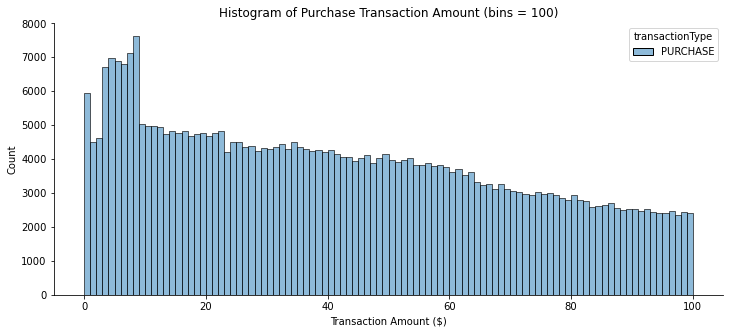

In [35]:
"""
After filtering to only purchases, we observe a peak slightly after
the first bin. We investigate below.
"""

bin_size=100
plt.figure(figsize = (12,5))
sns.histplot(data = df[(df['transactionAmount']<100) &
                       (df['transactionType']=='PURCHASE')],
             x = 'transactionAmount', 
             bins=bin_size,
             hue='transactionType')
plt.title('Histogram of Purchase Transaction Amount (bins = {})'.format(bin_size))
plt.xlabel('Transaction Amount ($)')
sns.despine()

#Get bins and counts
count, bins = np.histogram(df[(df['transactionAmount']<100) &
                       (df['transactionType']=='PURCHASE')]['transactionAmount'],
            bins=bin_size)

print("Start of bins: Count of transactions")
display(dict(zip(bins[0:10],count[0:10])))


## Statistical testing
The following cells evaluate which theoretical distributions provide the best fit to the emperical data. 
* I leverage the package "distfit" to automate this assessment and the visualization of results
* Manual evaluation of distribution fit would be executed using scipy. The key function calls are (normal distribution used as an example):
    1. loc, scale = scipy.stats.norm.fit(df['transactionAmount']) # fit the normal distribution
    2. pdf = stats.norm.pdf(x, loc=loc, scale=scale, *arg) # for some quantiles, x
    3. rss = np.sum(np.power(obs_y - pdf, 2.0)) # for the observed values at each point in x 

### All transactions

In [5]:
dist = distfit(todf=True)
results = dist.fit_transform(df['transactionAmount'])

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 3.50716e-05] [loc=136.986 scale=147.725]
[distfit] >[expon     ] [0.00 sec] [RSS: 9.53768e-07] [loc=0.000 scale=136.986]
[distfit] >[pareto    ] [17.8 sec] [RSS: 1.94811e-05] [loc=-2.669 scale=2.669]
[distfit] >[dweibull  ] [19.2 sec] [RSS: 2.36912e-05] [loc=85.670 scale=99.933]
[distfit] >[t         ] [14.3 sec] [RSS: 2.28822e-05] [loc=90.483 scale=80.574]
[distfit] >[genextreme] [73.2 sec] [RSS: 2.08673e-06] [loc=55.134 scale=61.596]
[distfit] >[gamma     ] [19.1 sec] [RSS: 5.64393e-07] [loc=-0.000 scale=193.686]
[distfit] >[lognorm   ] [47.1 sec] [RSS: 5.59986e-05] [loc=-0.000 scale=1.066]
[distfit] >[beta      ] [36.8 sec] [RSS: 1.28215e-07] [loc=-0.000 scale=17934.243]
[distfit] >[uniform   ] [0.00 sec] [RSS: 8.30131e-05] [loc=0.000 scale=2011.540]
[distfit] >[loggamma  ] [27.3 sec] [RSS: 3.54472e-05] [loc=-58577.958 scale=7525.446]
[distfit] >Compute confidence interval [parametric]


[distfit] >plot summary..


(<Figure size 1080x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Best fit: beta'}, xlabel='Distribution name', ylabel='RSS (lower is better)'>)

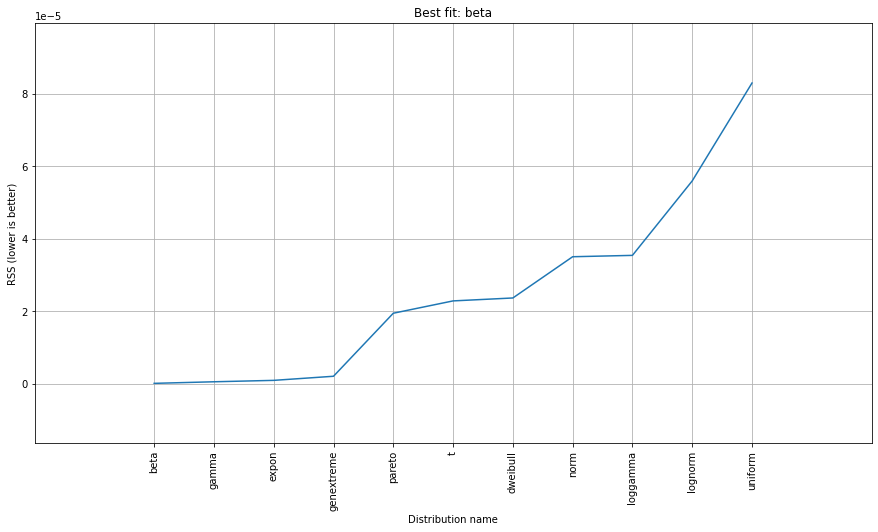

In [6]:
# Visually compare RSS for each fit
dist.plot_summary()

[distfit] >plot..


(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':'\nbeta\nRSS(a=0.800356, b=115.251, loc=-9.14657e-25, scale=17934.2)'}, xlabel='Values', ylabel='Frequency'>)

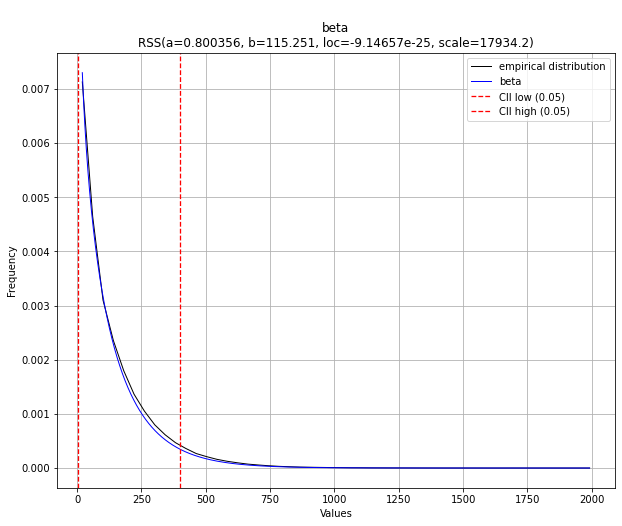

In [7]:
# Plot best fitting distribution
dist.plot()

### Only Purchases

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 3.1629e-05] [loc=140.622 scale=147.942]
[distfit] >[expon     ] [0.00 sec] [RSS: 4.15733e-07] [loc=0.000 scale=140.622]
[distfit] >[pareto    ] [19.7 sec] [RSS: 2.2788e-05] [loc=-1.929 scale=1.929]
[distfit] >[dweibull  ] [19.6 sec] [RSS: 2.12826e-05] [loc=89.880 scale=100.478]
[distfit] >[t         ] [15.6 sec] [RSS: 2.02869e-05] [loc=94.395 scale=81.147]
[distfit] >[genextreme] [44.5 sec] [RSS: 2.10101e-06] [loc=59.048 scale=62.470]
[distfit] >[gamma     ] [17.5 sec] [RSS: 9.46014e-08] [loc=-0.000 scale=150.991]
[distfit] >[lognorm   ] [35.0 sec] [RSS: 4.0455e-05] [loc=-0.000 scale=1.156]
[distfit] >[beta      ] [32.6 sec] [RSS: 1.34097e-07] [loc=-0.000 scale=20487.399]
[distfit] >[uniform   ] [0.00 sec] [RSS: 7.892e-05] [loc=0.000 scale=2011.540]
[distfit] >[loggamma  ] [24.2 sec] [RSS: 3.233e-05] [loc=-64069.869 scale=8087.822]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot summary

(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':'\ngamma\nRSS(a=0.909978, loc=-2.78652e-28, scale=150.991)'}, xlabel='Values', ylabel='Frequency'>)

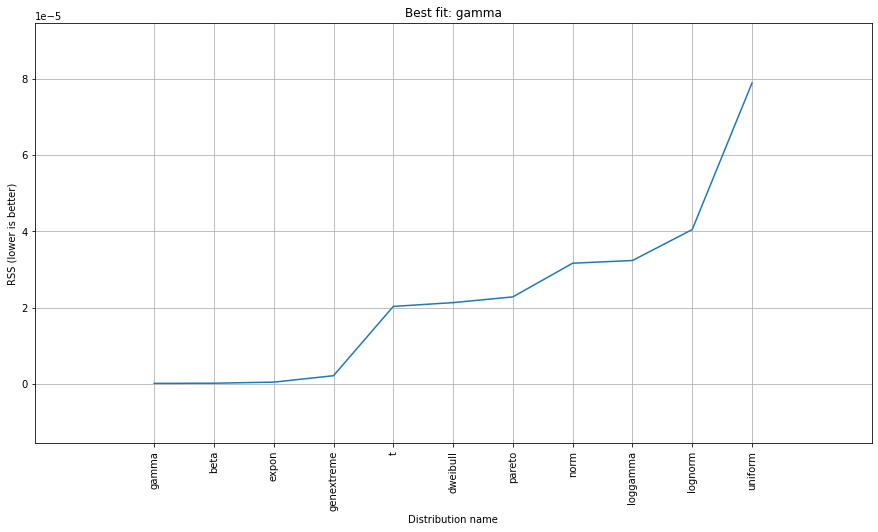

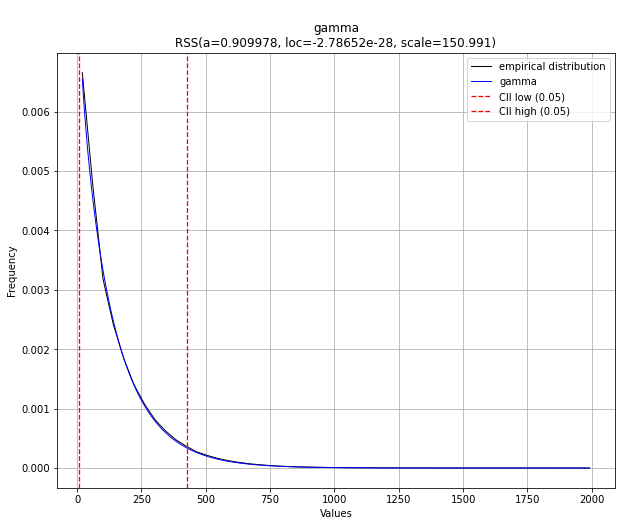

In [19]:
dist = distfit(todf=True)
results = dist.fit_transform(df[df['transactionType']=='PURCHASE']['transactionAmount'])

# Visually compare RSS for each fit
dist.plot_summary()

# Plot best fitting distribution
dist.plot()